<a href="https://colab.research.google.com/github/juanluisrosaramos/document_classification/blob/master/signed_text.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import matplotlib.pyplot as plt
import numpy as np # linear algebra
from __future__ import print_function
import pandas as pd


train_df = pd.read_csv("train.csv", sep=",")
test_df = pd.read_csv("test.csv", sep=",")

# Working with the text of the documents
Exploring Raw_text column to see if there are clear differences in text between the two type of documents(signed or not)


*   Delete spanish stopwords
*   Tokenization
*   Count word frequency



In [0]:
import string
import nltk
from nltk.stem import SnowballStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
from sklearn import feature_extraction, model_selection, naive_bayes, metrics, svm
from IPython.display import Image
import warnings
warnings.filterwarnings("ignore")
%matplotlib inline  


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [0]:
stop_words = stopwords.words('spanish')
# tokenization 
tokenized_doc = train_df['Raw_text'].apply(lambda x: x.split())

In [0]:
# remove stop-words 
tokenized_doc = tokenized_doc.apply(lambda x: [item for item in x if item not in stop_words])

In [0]:
#load the new raw text into pandas dataframe
detokenized_doc = [] 
for i in range(len(train_df)): 
    t = ' '.join(tokenized_doc[i]) 
    detokenized_doc.append(t) 
train_df['Raw_text'] = detokenized_doc


# Count word frequency

In [0]:
count1 = Counter(" ".join(train_df[train_df['Target_sign']==1]["Raw_text"]).split()).most_common(20)
df1 = pd.DataFrame.from_dict(count1)
df1 = df1.rename(columns={0: "words in signed", 1 : "count"})
count2 = Counter(" ".join(train_df[train_df['Target_sign']==0]["Raw_text"]).split()).most_common(20)
df2 = pd.DataFrame.from_dict(count2)
df2 = df2.rename(columns={0: "words in non signed", 1 : "count_"})

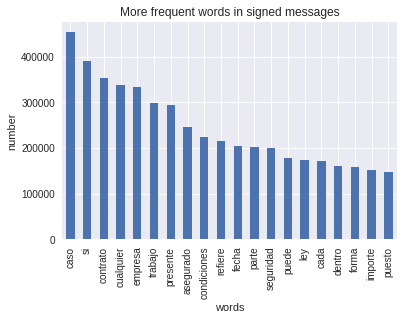

In [0]:
df1.plot.bar(legend = False)
y_pos = np.arange(len(df1["words in signed"]))
plt.xticks(y_pos, df1["words in signed"])
plt.title('More frequent words in signed messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

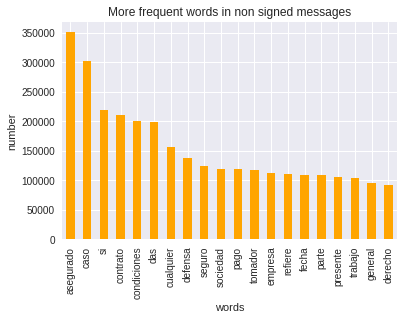

In [0]:
df2.plot.bar(legend = False, color = 'orange')
y_pos = np.arange(len(df2["words in non signed"]))
plt.xticks(y_pos, df2["words in non signed"])
plt.title('More frequent words in non signed messages')
plt.xlabel('words')
plt.ylabel('number')
plt.show()

# Training a model
We detected just a few words differences between signed and not signed dosuments. Specially with the word "asegurado" 
We can explore how a classifying model will perform with this text.

**Bag-of-Words (BoW)**
BoW counts the number of times that tokens appear in every document of the collection. It returns a matrix with the next characteristics:

Number of columns = number of unique tokens in the whole collection of documents (vocabulary).

Number of rows = number of documents in the whole collection of documents.

In [0]:
#Convert a collection of text documents to a matrix of token counts
f = feature_extraction.text.CountVectorizer()
X = f.fit_transform(train_df["Raw_text"])
np.shape(X)

(132637, 21205)

Build the training and test partition (a 20%) from test.csv 

In [0]:
#Split arrays or matrices into random train and test subsets

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, train_df['Target_sign'], test_size=0.20, random_state=42)
print([np.shape(X_train), np.shape(X_test)])

[(106109, 21205), (26528, 21205)]


# Training a Multinomial Naive Bayes model
The multinomial Naive Bayes classifier is suitable for classification with discrete features (e.g., word counts for text classification). We will train multiple Naive Bayes classifiers  to explore different parametrization.

In [0]:
list_alpha = np.arange(1/200000, 20, 0.11)
score_train = np.zeros(len(list_alpha))
score_test = np.zeros(len(list_alpha))
recall_test = np.zeros(len(list_alpha))
precision_test= np.zeros(len(list_alpha))
count = 0
for alpha in list_alpha:
    bayes = naive_bayes.MultinomialNB(alpha=alpha)
    bayes.fit(X_train, y_train)
    score_train[count] = bayes.score(X_train, y_train)
    score_test[count]= bayes.score(X_test, y_test)
    recall_test[count] = metrics.recall_score(y_test, bayes.predict(X_test))
    precision_test[count] = metrics.precision_score(y_test, bayes.predict(X_test))
    count = count + 1 

In [0]:
matrix = np.matrix(np.c_[list_alpha, score_train, score_test, recall_test, precision_test])
models = pd.DataFrame(data = matrix, columns = 
             ['alpha', 'Train Accuracy', 'Test Accuracy', 'Test Recall', 'Test Precision'])
models.head(n=10)

,alpha,Train Accuracy,Test Accuracy,Test Recall,Test Precision
0,0.000005,0.705115,0.698658,0.959099,0.701442
1,0.110005,0.703937,0.698545,0.959661,0.701190
2,0.220005,0.703814,0.698432,0.959717,0.701088
3,0.330005,0.703626,0.698545,0.959998,0.701091
4,0.440005,0.703541,0.698470,0.959942,0.701050
5,0.550005,0.703494,0.698470,0.959885,0.701067
6,0.660005,0.703446,0.698507,0.959942,0.701079
7,0.770005,0.703428,0.698583,0.960054,0.701104
8,0.880005,0.703362,0.698583,0.960110,0.701087
9,0.990005,0.703352,0.698583,0.960110,0.701087


In [0]:
model = naive_bayes.MultinomialNB(alpha=alpha)
model.fit(X_train, y_train)
preds = model.predict(X_test)
accuracy = (preds == y_test).mean()
print(accuracy)

0.6968863088057901


In [0]:
def print_top10(vectorizer, clf, class_labels):
    """Prints features with the highest coefficient values, per class"""
    feature_names = vectorizer.get_feature_names()
    for i, class_label in enumerate(class_labels):
        top10 = np.argsort(clf.coef_[0])[-10:]
        print("%s: %s" % (class_label,
              " ".join(feature_names[j] for j in top10)))
        
def show_most_informative_features(vectorizer, clf, n=20):
    feature_names = vectorizer.get_feature_names()
    coefs_with_fns = sorted(zip(clf.coef_[0], feature_names))
    top = zip(coefs_with_fns[:n], coefs_with_fns[:-(n + 1):-1])
    for (coef_1, fn_1), (coef_2, fn_2) in top:
        print ("\t%.4f\t%-15s\t\t%.4f\t%-15s" % (coef_1, fn_1, coef_2, fn_2))
        
show_most_informative_features(f,model)


	-14.1895	abandonan      		-4.3823	caso           
	-14.1895	abastecido     		-4.5304	si             
	-14.1895	abejar         		-4.6333	contrato       
	-14.1895	abocan         		-4.6835	cualquier      
	-14.1895	abres          		-4.6984	empresa        
	-14.1895	absorbe        		-4.8080	trabajo        
	-14.1895	acababa        		-4.8150	presente       
	-14.1895	acaten         		-4.9952	asegurado      
	-14.1895	aceitunillo    		-5.0833	condiciones    
	-14.1895	acentuado      		-5.1226	refiere        
	-14.1895	achata         		-5.1851	fecha          
	-14.1895	aclare         		-5.1882	parte          
	-14.1895	acogiendo      		-5.2118	seguridad      
	-14.1895	acometan       		-5.3185	puede          
	-14.1895	acopiara       		-5.3497	ley            
	-14.1895	acordamos      		-5.3519	cada           
	-14.1895	acordonando    		-5.4177	dentro         
	-14.1895	acosar         		-5.4428	forma          
	-14.1895	acosto         		-5.4704	importe        
	-14.1895	acromio        		-5.5

In [0]:
best_index = models['Test Precision'].idxmax()
models.iloc[best_index, :]
#models[models['Test Precision']==1].head(n=5)

alpha             0.000005
Train Accuracy    0.705115
Test Accuracy     0.698658
Test Recall       0.959099
Test Precision    0.701442
Name: 0, dtype: float64

We are having specially low Precision that was a requirement of the customer: "predicting that a document will be signed when in reality it won’t is slightly worse than otherwise"

Let's print the confusion matrix of the test partition (builded from the train.csv). And we see too many TP results



In [0]:
m_confusion_test = metrics.confusion_matrix(y_test, bayes.predict(X_test))
pd.DataFrame(data = m_confusion_test, columns = ['Predicted 0', 'Predicted 1'],
            index = ['Actual 0', 'Actual 1'])

,Predicted 0,Predicted 1
Actual 0,1362,7367
Actual 1,674,17125


I will not use the RawText